<a href="https://colab.research.google.com/github/sumanyurosha/tensorflow-specialization/blob/master/Practicing_on_Sarcasm_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Downloading the Sarcasm Dataset**

In [3]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-10-29 18:26:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-10-29 18:26:12 (201 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
import json

with open("/tmp/sarcasm.json") as f:
    datastore = json.load(f)

# **2. Data Preprocessing**

In [5]:
headlines = []
urls = []
labels = []

for item in datastore:
    headlines.append(item["headline"])
    urls.append(item["article_link"])
    labels.append(item["is_sarcastic"])


print("Size of dataset: {}".format(len(headlines)))

Size of dataset: 26709


In [6]:
headlines[:5]

["former versace store clerk sues over secret 'black code' for minority shoppers",
 "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
 "mom starting to fear son's web series closest thing she will have to grandchild",
 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
 'j.k. rowling wishes snape happy birthday in the most magical way']

In [7]:
labels[:5]

[0, 0, 1, 1, 0]

In [14]:
oov_token = "<OOV>"
training_size = 20000
vocab_size = 10000
embedding_dim = 256
trunc_type = "post"
pad_type = "post"

In [9]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(headlines)

sequences = tokenizer.texts_to_sequences(headlines)
padded_sequences = pad_sequences(sequences, padding=pad_type, truncating=trunc_type)

max_len = len(padded_sequences[0])
print(max_len)

print("Headline : {}".format(headlines[0]))
print("Tokenized Sequence : {}".format(sequences[0]))
print("Padded Sequence : {}".format(padded_sequences[0]))

40
Headline : former versace store clerk sues over secret 'black code' for minority shoppers
Tokenized Sequence : [308, 1, 679, 3337, 2298, 48, 382, 2576, 1, 6, 2577, 8434]
Padded Sequence : [ 308    1  679 3337 2298   48  382 2576    1    6 2577 8434    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [10]:
train_padded = np.array(padded_sequences[:training_size])
valid_padded = np.array(padded_sequences[training_size:])

train_labels = np.array(labels[:training_size])
valid_labels = np.array(labels[training_size:])

print(len(train_padded))
print(len(valid_padded))

20000
6709


In [11]:
import matplotlib.pyplot as plt

def plot_graph(history, string):
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.legend([string, "val_" + string])
    plt.show()

# **Model with Multiple LSTM Layers**

In [16]:
from keras.regularizers import L2

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(64, return_sequences=True, dropout=0.2),
    keras.layers.LSTM(32, dropout=0.2 ),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=5, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 256)           2560000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40, 64)            82176     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,654,625
Trainable params: 2,654,625
Non-trainable params: 0
____________________________________________

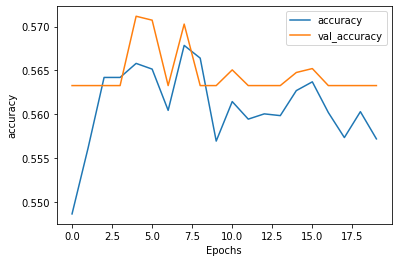

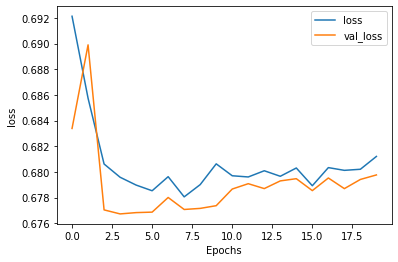

In [13]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")

In [17]:
from keras.regularizers import L2

model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Conv1D(32, 5),
    keras.layers.LSTM(1024, return_sequences=True, dropout=0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_padded, train_labels, epochs=20, 
                    validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 256)           2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, 36, 32)            40992     
_________________________________________________________________
lstm_6 (LSTM)                (None, 36, 1024)          4329472   
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 1024)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 36, 1)             1025      
Total params: 6,931,489
Trainable params: 6,931,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
625/625 [==============================] - 25s 40ms/step - loss: 0.4895 - accuracy: 0.7730 - val_lo

In [18]:
bidirectional_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
    keras.layers.Dropout(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True,
                                                 dropout=0.2)),
    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True,
                                                 dropout=0.2)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid"),
])

bidirectional_model.summary()

bidirectional_model.compile(loss="binary_crossentropy", optimizer="adam",
                            metrics=["accuracy"])

history = bidirectional_model.fit(train_padded, train_labels, epochs=20, 
          validation_data=(valid_padded, valid_labels), verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 40, 256)           2560000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 1024)          3149824   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 1024)          6295552   
_________________________________________________________________
dropout_8 (Dropout)          (None, 40, 1024)          0         
_________________________________________________________________
dense_4 (Dense)              (None, 40, 1)             1025      
Total params: 12,006,401
Trainable params: 12,006,401
Non-trainable params: 0
__________________________________________

KeyboardInterrupt: ignored

In [ ]:
plot_graph(history, "accuracy")
plot_graph(history, "loss")